# Tutorial on Face recogntion


**Problem to solve**: define a space of image feature that allows to represent objects based on their appearance or a set of local features in the image.


Documentation [Face recognition skimage](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)



**Steps:**

1. Define an appropiate representation (descriptors objects):
    - Normally, reduce size of the data preserving the invariance and removing redundant dimensions.


2. Tran a classifier from a set of examples with their descriptors.


3. Recognize a new face example using the learned model.

## 1. Representation - Dimensionality and redundancy

Instead of storing features or 3D models, directly store a collection of many views of the objects. 

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.png" width=400, height=400>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.png" width=800, height=800>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.png" width=500, height=500>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<img src="notebook_images/mean_image.png">

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.png" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


### Imports

In [2]:
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split #we need to create training and test for the classifier
from sklearn.datasets import fetch_lfw_people # we will use this dataset
from sklearn.metrics import classification_report # to visualize the classification results
from sklearn.decomposition import PCA
from time import time

### Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*

**Parameters**
- data_home: optional, default: None
Specify another download and cache folder for the datasets. By default all scikit-learn data is stored in ‘~/scikit_learn_data’ subfolders.

- funneled: boolean, optional, default: True
Download and use the funneled variant of the dataset.

- resize: float, optional, default 0.5
Ratio used to resize the each face picture.

- min_faces_per_person: int, optional, default None
The extracted dataset will only retain pictures of people that have at least min_faces_per_person different pictures.

- color: boolean, optional, default False
Keep the 3 RGB channels instead of averaging them to a single gray level channel. If color is True the shape of the data has one more dimension than the shape with color = False.

- slice_: optional.
Provide a custom 2D slice (height, width) to extract the ‘interesting’ part of the jpeg files and avoid use statistical correlation from the background

- download_if_missing: optional, True by default
If False, raise a IOError if the data is not locally available instead of trying to download the data from the source site.

- return_X_y: boolean, default=False.
If True, returns (dataset.data, dataset.target) instead of a Bunch object. See below for more information about the dataset.data and dataset.target object.


**Returns**
- dataset:  
Dictionary-like object, with the following attributes.

- data: numpy array of shape (13233, 2914)
Each row corresponds to a ravelled face image of original size 62 x 47 pixels. Changing the slice_ or resize parameters will change the shape of the output.

- images: numpy array of shape (13233, 62, 47)
Each row is a face image corresponding to one of the 5749 people in the dataset. Changing the slice_ or resize parameters will change the shape of the output.

- target: numpy array of shape (13233,)
Labels associated to each face image. Those labels range from 0-5748 and correspond to the person IDs.

- DESCR: string
Description of the Labeled Faces in the Wild (LFW) dataset.

- (data, target): tuple if return_X_y is True

In [3]:
eigen_faces = fetch_lfw_people(min_faces_per_person=100)

_, h, w = eigen_faces.images.shape
X = eigen_faces.data
y = eigen_faces.target
target_names = eigen_faces.target_names

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255



In [6]:
import numpy as np
from numpy import unique

print(X.shape) 
print(target_names)
print(np.unique(y))
print('Image height: ', h, 'width: ', w, '1D size: ', h*w)

(1140, 2914)
['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
[0 1 2 3 4]
Image height:  62 width:  47 1D size:  2914


First we need to split the data into training and test dataset. Why?

We can use:

[*sklearn.model_selection.train_test_split(*arrays, **options)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Split arrays or matrices into random train and test subsets



In [7]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.


In [8]:

n_components = 150
pca = PCA(n_components=n_components).fit(X_train)

What is the variable *pca*?

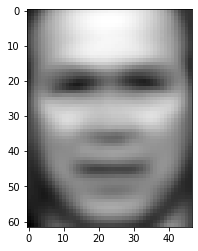

In [9]:
# One interesting part of PCA is that it computes the “mean” face, which can be interesting to examine:
plt.imshow(pca.mean_.reshape(eigen_faces.images[0].shape),
           cmap='gray')

Visualize the eigenfaces

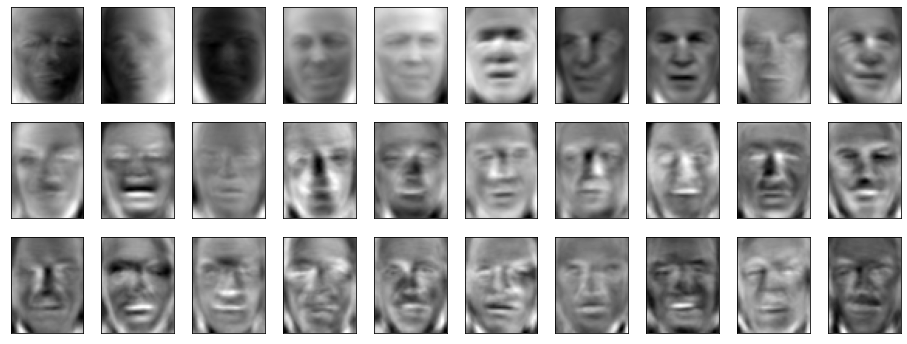

In [10]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(eigen_faces.images[0].shape),
              cmap='gray')

The base components (“eigenfaces”) are ordered by their importance from top-left to bottom-right. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training and test data onto the PCA basis:

In [12]:
# apply PCA transformation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Shell we apply the same to the variable y?

These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face.


<br/>
<img src="notebook_images/eigenfaces_image.png">

**Exercise:** What is the purpose of the PCA tool?

## 2. Train a classifier from a set of examples with their descriptors

#### Train an Adaboost classifier without PCA

In [14]:
# Train a Adaboost classifier

from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ada_model = AdaBoostClassifier(n_estimators=100, random_state=0) #initialization
ada_model.fit(X_train, y_train) #training
y_pred = ada_model.predict(X_test) #classification
score = ada_model.score(X_test, y_test) #computing accuracy
time_without_pca = time() - t0
print("Done in %0.3fs" % (time_without_pca))

Done in 21.133s


In [18]:
print('The score is: ', score)

The score is:  0.6345029239766082


The classifier is correct on a good number of images given the simplicity of its learning model! Using a linear classifier on the features derived from the pixel-level data, the algorithm correctly identifies a large number of the people in the images.

Again, we can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification:

To this purpose we will use:

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

that builds a text report showing the main classification metrics.

- y_true: 1d array-like, or label indicator array / sparse matrix
Ground truth (correct) target values.

- y_pred: 1d array-like, or label indicator array / sparse matrix
Estimated targets as returned by a classifier.

- labels: array, shape = [n_labels]
Optional list of label indices to include in the report.

- target_names: list of strings
Optional display names matching the labels (same order).

- sample_weight: array-like of shape (n_samples,), default=None
Sample weights.

- digits: int
Number of digits for formatting output floating point values. When output_dict is True, this will be ignored and the returned values will not be rounded.

- output_dict: bool (default = False)
If True, return output as dict


- zero_division: “warn”, 0 or 1, default=”warn”
Sets the value to return when there is a zero division. If set to “warn”, this acts as 0, but warnings are also raised.

**Returns**
- report: string / dict
Text summary of the precision, recall, F1 score for each class. Dictionary returned if output_dict is True. Dictionary has the following structure:

{'label 1': {'precision':0.5,
             'recall':1.0,
             'f1-score':0.67,
             'support':1},
 'label 2': { ... },
  ...
}

The support is the number of occurrences of each class in y_true.

In [39]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.67      0.57      0.61        67
  Donald Rumsfeld       0.83      0.24      0.37        42
    George W Bush       0.64      0.88      0.74       165
Gerhard Schroeder       0.73      0.23      0.35        35
       Tony Blair       0.46      0.52      0.49        33

         accuracy                           0.64       342
        macro avg       0.67      0.49      0.51       342
     weighted avg       0.66      0.64      0.61       342



The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). 

Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

What is:
- accuracy (score)
- precision
- recall
- f1-score
- support
- macro avg
- weighted avg?



<br/>
<img src="notebook_images/Precisionrecall.png">

Accuracy: $\sum TP_i/|Dataset|$

The support is the number of occurrences of each class in y_true.

Precision: $Pr=TP/(TP+FP)$

Recall: $Rc=TP/(TP+FN)$

F1-score: $F1=2*Pr*Rc/(Pr+Rc)$

A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

To illustrate why, take for example precision 𝑃𝑟=𝑇𝑃/(𝑇𝑃+𝐹𝑃). Let's imagine you have a One-vs-All (there is only one correct class output per example) multi-class classification system with four classes and the following numbers when tested:

- Class A: 1 TP and 1 FP
- Class B: 10 TP and 90 FP
- Class C: 1 TP and 1 FP
- Class D: 1 TP and 1 FP

You can see easily that 𝑃𝑟𝐴=𝑃𝑟𝐶=𝑃𝑟𝐷=0.5, whereas 𝑃𝑟𝐵=0.1.

A macro-average will then compute: 
𝑃𝑟=(0.5+0.1+0.5+0.5)/4=0.4

A micro-average will compute: 
𝑃𝑟=(1+10+1+1)/(2+100+2+2)=0.123

These are quite different values for precision. Intuitively, in the macro-average the "good" precision (0.5) of classes A, C and D is contributing to maintain a "decent" overall precision (0.4). While this is technically true (across classes, the average precision is 0.4), it is a bit misleading, since a large number of examples are not properly classified. These examples predominantly correspond to class B, so they only contribute 1/4 towards the average in spite of constituting 94.3% of your test data. The micro-average will adequately capture this class imbalance, and bring the overall precision average down to 0.123 (more in line with the precision of the dominating class B (0.1)).

For computational reasons, it may sometimes be more convenient to compute class averages and then macro-average them. If class imbalance is known to be an issue, there are several ways around it. One is to report not only the macro-average, but also its standard deviation (for 3 or more classes). Another is to compute a weighted macro-average, in which each class contribution to the average is weighted by the relative number of examples available for it. In the above scenario, we obtain:

$𝑃𝑟𝑚𝑎𝑐𝑟𝑜−𝑚𝑒𝑎𝑛=0.25*0.5+0.25*0.1+0.25*0.5+0.25*0.5=0.4, 𝑃𝑟𝑚𝑎𝑐𝑟𝑜−𝑠𝑡𝑑𝑒𝑣=0.173$

$𝑃𝑟𝑚𝑎𝑐𝑟𝑜−𝑤𝑒𝑖𝑔ℎ𝑡𝑒𝑑=0.0189*0.5+0.943*0.1+0.0189*0.5+0.0189*0.5=0.009+0.094+0.009+0.009=0.123$

The large standard deviation (0.173) already tells us that the 0.4 average does not stem from a uniform precision among classes, but it might be just easier to compute the weighted macro-average, which in essence is another way of computing the micro-average.

A weighted average is the average of values which are scaled by importance. The weighted average of values is the sum of weights times values divided by the sum of the weights.


#### Train an Adaboost classifier with PCA

In [33]:
# Train a Adaboost classifier

from sklearn.ensemble import AdaBoostClassifier

t1 = time()
ada_model_pca = AdaBoostClassifier(n_estimators=10, random_state=0)
ada_model_pca.fit(X_train_pca, y_train)

y_pred_pca = ada_model_pca.predict(X_test_pca)

score_pca = ada_model_pca.score(X_test_pca, y_test)

time_pca = time() - t1

print("Done in %0.3fs" % (time_pca))

Done in 0.167s


In [34]:
print('The accuracy of the classifier in the PCA space is: ', score_pca)
print(classification_report(y_test, y_pred_pca, target_names=target_names))

The accuracy of the classifier in the PCA space is:  0.5497076023391813
                   precision    recall  f1-score   support

     Colin Powell       0.39      0.45      0.42        71
  Donald Rumsfeld       0.53      0.20      0.29        40
    George W Bush       0.64      0.83      0.72       154
Gerhard Schroeder       0.50      0.30      0.37        30
       Tony Blair       0.42      0.23      0.30        47

         accuracy                           0.55       342
        macro avg       0.50      0.40      0.42       342
     weighted avg       0.53      0.55      0.52       342



#### Adaboost with vs without PCA

[21.132902145385742, 0.1673879623413086]


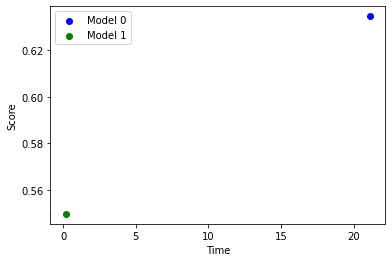

In [35]:
#Plot performance & time
import matplotlib.colors as mcolors
colors = list(mcolors.BASE_COLORS)

def plotPerfomance(times, scores):
    
    for index_model, (time, score) in enumerate(zip(times, scores)):
    
        plt.scatter(time, score, c=colors[index_model], 
                    label='Model {}'.format(index_model))
        plt.legend()

    plt.xlabel('Time')
    plt.ylabel('Score')

    plt.show()

times = [time_without_pca, time_pca]
scores = [score, score_pca]
    
print(times)
plotPerfomance(times, scores)

**Exercise:** Does computing time change using PCA? How?

**Exercise:** Which of both (with and without PCA) does give better results?

**Exercise:** How does the result change if we change the number of components in PCA?

**Exercise:** How does the result change if we change the number of estimators in the Adaboost?

## 3. Recognize a new face example using the learned model

Project the new face in the new space:

<br/>
<br/>
<img src="notebook_images/eigenfaces_image.png">

In [39]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure(figsize=(10,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

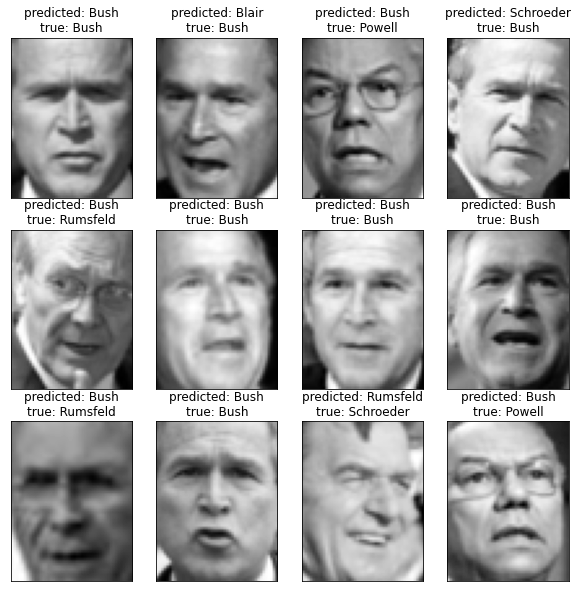

In [46]:
def predict(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
 
prediction_titles = list(predict(y_pred, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)

#Apply it on the pca predictions

**Exercise:** Which model makes the predictions betters? Try different parameters and plot the performances with the *plotPerformance()* function.